# Predicting Stanley Cup Champion

<a id="top"></a>
## Table of Contents

#### Imports
- [Imports](#imports)

#### Functions
- [Defining Functions](#functions)

#### Dataframe of 2017-2023 Season Data
- [Creating Historical Dataframe](#dataframe)

#### 2022 Season Predictions
- [2022 Model](#2022model)
- [2022 Plot](#2022plot)
- [Simulating 2022 Playoffs - No Randomness](#2022simulatingnorandom)
- [Simulating 2022 Playoffs - With Randomness](#2022simulatingrandom)

#### 2023 Season Predictions
- [2023 Model](#2023model)
- [2023 Plot](#2023plot)
- [Simulating 2023 Playoffs - No Randomness](#2023simulatingnorandom)
- [Simulating 2023 Playoffs - With Randomness](#2023simulatingrandom)

<a id="imports"></a>
## Imports
[Return to top](#top)

In [32]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

<a id="functions"></a>
## Defining Functions
[Return to top](#top)

In [33]:
def process_year(year, champion_team):
    
    regular_df = pd.read_csv(f'reg_{year}.csv', header=1)
    regular_df = regular_df.rename(columns={'Unnamed: 1': 'Team'})
    advanced_df = pd.read_csv(f'adv_{year}.csv', header=1)
    advanced_df = advanced_df.rename(columns={'Unnamed: 1': 'Team'})

    data = pd.merge(advanced_df, regular_df, on='Team', suffixes=('_adv', '_reg'))

    data['Stanley_Cup_Champion'] = 0
    data.loc[data['Team'] == champion_team, 'Stanley_Cup_Champion'] = 1
    data['Year'] = year

    return data

def simulate_match(team1, team2, team_probs):
    prob1 = team_probs[team1]
    prob2 = team_probs[team2]

    if prob1 > prob2:
        return team1
    else:
        return team2
    
def simulate_match_random(team1, team2, team_probs, strength=10):
    prob1 = team_probs[team1]
    prob2 = team_probs[team2]
    
    weighted_prob1 = (prob1 ** strength) / ((prob1 ** strength) + (prob2 ** strength))

    if random.random() < weighted_prob1:
        return team1
    else:
        return team2

<a id="dataframe"></a>
## Creating Dataframe for Model
[Return to top](#top)
- Merged regular and advanced season stats from 2017-2023

In [34]:
years = range(2017, 2024)
champions = ['Pittsburgh Penguins*', 'Washington Capitals*', 'St. Louis Blues*', 'Tampa Bay Lightning*', 'Tampa Bay Lightning*', 'Colorado Avalanche*', '']
historical_data = pd.concat([process_year(year, champion) for year, champion in zip(years, champions)], ignore_index=True)

historical_data.head()

,Rk_adv,Team,S%_adv,SV%_adv,PDO,CF,CA,CF%,FF,FA,...,SHA,PIM/G,oPIM/G,S,S%_reg,SA,SV%_reg,SO,Stanley_Cup_Champion,Year
0,1,Washington Capitals*,8.4,0.941,102.5,3658,3405,51.8,2696,2546,...,3,9.1,8.7,2495,10.5,2282,0.922,12,0,2017
1,2,Pittsburgh Penguins*,7.9,0.932,101.0,3810,3788,50.1,2874,2735,...,7,8.6,9.0,2745,10.1,2671,0.914,5,1,2017
2,3,Chicago Blackhawks*,7.6,0.937,101.3,3779,3713,50.4,2713,2716,...,7,7.1,7.9,2508,9.6,2574,0.918,4,0,2017
3,4,Columbus Blue Jackets*,7.6,0.936,101.2,3719,3677,50.3,2772,2727,...,2,8.7,8.6,2540,9.7,2489,0.922,8,0,2017
4,5,Minnesota Wild*,8.4,0.931,101.5,3650,3744,49.4,2769,2778,...,3,8.2,8.4,2527,10.4,2465,0.916,5,0,2017


<a id="2022model"></a>
## 2022 Model - Averaging Multiple Random Seeds
[Return to top](#top)
- 2022 is explored first to check models viability
- When using all team data the correct choice of Colorado Avalanche are selected

In [35]:
data = historical_data

teams = data['Team']

data = data.drop(columns=['Team'])

X = data.drop(columns=['Stanley_Cup_Champion', 'Year'])
y = data['Stanley_Cup_Champion']

train_data = data[data['Year'] < 2022]
X_train = train_data.drop(columns=['Stanley_Cup_Champion', 'Year'])
y_train = train_data['Stanley_Cup_Champion']

data_2022 = data[data['Year'] == 2022]
X_2022 = data_2022.drop(columns=['Stanley_Cup_Champion', 'Year'])

team_prob_dict = {}
feature_importances_list = []

for random_seed in range(1, 100):

    clf = RandomForestClassifier(n_estimators=100, random_state=random_seed)
    clf.fit(X_train, y_train)

    feature_importances_list.append(clf.feature_importances_) 

    team_probabilities = clf.predict_proba(X_2022)[:, 1] 
    
    for team, prob in zip(teams[data_2022.index], team_probabilities):
        if team not in team_prob_dict:
            team_prob_dict[team] = [prob]
        else:
            team_prob_dict[team].append(prob)

team_mean_prob_dict = {team: np.mean(probs) for team, probs in team_prob_dict.items()}

sorted_team_probs = sorted(team_mean_prob_dict.items(), key=lambda x: x[1], reverse=True)

for team, prob in sorted_team_probs:
    print(f"{team}: {prob:.2%}")

average_feature_importances = np.mean(feature_importances_list, axis=0)
sorted_indices = np.argsort(average_feature_importances)[::-1]

feature_names = X.columns

print("Top 10 Most Important Predictors:")
for f in range(10):
    print("%d. %s (%f)" % (f+1, feature_names[sorted_indices[f]], average_feature_importances[sorted_indices[f]]))

sorted_team_names, sorted_team_probs = zip(*sorted_team_probs)

team_probs = {}
for i in range(len(sorted_team_names)):
    team_probs[sorted_team_names[i]] = sorted_team_probs[i]

Colorado Avalanche*: 36.82%
Florida Panthers*: 36.62%
Minnesota Wild*: 35.20%
Tampa Bay Lightning*: 34.93%
Carolina Hurricanes*: 31.61%
Calgary Flames*: 29.32%
St. Louis Blues*: 28.93%
Toronto Maple Leafs*: 27.52%
Boston Bruins*: 20.55%
Edmonton Oilers*: 15.99%
Pittsburgh Penguins*: 15.70%
New York Rangers*: 14.62%
Nashville Predators*: 11.69%
Washington Capitals*: 6.77%
Winnipeg Jets: 6.56%
Columbus Blue Jackets: 6.29%
New York Islanders: 5.39%
Los Angeles Kings*: 5.28%
Vegas Golden Knights: 4.85%
New Jersey Devils: 3.81%
Vancouver Canucks: 3.61%
Dallas Stars*: 3.03%
Arizona Coyotes: 2.86%
Philadelphia Flyers: 1.34%
Ottawa Senators: 1.31%
Montreal Canadiens: 0.99%
Anaheim Ducks: 0.92%
Detroit Red Wings: 0.63%
San Jose Sharks: 0.41%
Buffalo Sabres: 0.13%
Chicago Blackhawks: 0.12%
Seattle Kraken: 0.10%
Top 10 Most Important Predictors:
1. HDCO% (0.044350)
2. CA (0.037679)
3. FA (0.037068)
4. HDF (0.032420)
5. PIM/G (0.032187)
6. xGF (0.031298)
7. S%_reg (0.030296)
8. S (0.026237)
9. HDF

<a id="2022plot"></a>
## Plotting 2022 Model
[Return to top](#top)

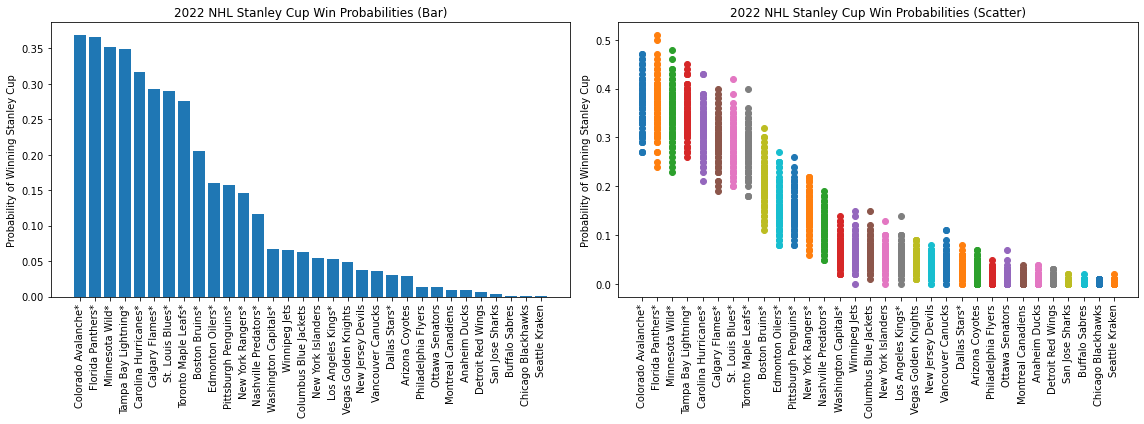

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.bar(sorted_team_names, sorted_team_probs)
ax1.set_xticks(range(len(sorted_team_names)))
ax1.set_xticklabels(sorted_team_names, rotation=90)
ax1.set_ylabel('Probability of Winning Stanley Cup')
ax1.set_title('2022 NHL Stanley Cup Win Probabilities (Bar)')

for team in sorted_team_names:
    probs = team_prob_dict[team]
    ax2.scatter([team] * len(probs), probs, label=team)

ax2.set_ylabel('Probability of Winning Stanley Cup')
ax2.set_title('2022 NHL Stanley Cup Win Probabilities (Scatter)')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

<a id="2022simulatingnorandom"></a>
## Simulating 2022 Playoffs - No Randomness
[Return to top](#top)
- This cell will provide the same output each time based on team probabilities

In [37]:
matchups = [
    ("Florida Panthers*", "Washington Capitals*"),
    ("Toronto Maple Leafs*", "Tampa Bay Lightning*"),
    ("Carolina Hurricanes*", "Boston Bruins*"),
    ("New York Rangers*", "Pittsburgh Penguins*"),
    ("Colorado Avalanche*", "Nashville Predators*"),
    ("Minnesota Wild*", "St. Louis Blues*"),
    ("Calgary Flames*", "Dallas Stars*"),
    ("Edmonton Oilers*", "Los Angeles Kings*"),
]

rounds = 1
matchup_results = {}

while len(matchups) > 0:
    winners = []
    round_results = {}
    for team1, team2 in matchups:
        winner = simulate_match(team1, team2, team_probs)
        winners.append(winner)
        round_results[f"{team1} vs {team2}"] = f"{winner} wins"
    
    matchup_results[f"Round {rounds}"] = round_results
    rounds += 1

    if len(winners) > 1:
        matchups = [(winners[i], winners[i+1]) for i in range(0, len(winners), 2)]
    else:
        break

for round_name, results in matchup_results.items():
    print(round_name)
    for matchup, result in results.items():
        print(matchup, ":", result)
    print()

print("Champion:", winners[0])

Round 1
Florida Panthers* vs Washington Capitals* : Florida Panthers* wins
Toronto Maple Leafs* vs Tampa Bay Lightning* : Tampa Bay Lightning* wins
Carolina Hurricanes* vs Boston Bruins* : Carolina Hurricanes* wins
New York Rangers* vs Pittsburgh Penguins* : Pittsburgh Penguins* wins
Colorado Avalanche* vs Nashville Predators* : Colorado Avalanche* wins
Minnesota Wild* vs St. Louis Blues* : Minnesota Wild* wins
Calgary Flames* vs Dallas Stars* : Calgary Flames* wins
Edmonton Oilers* vs Los Angeles Kings* : Edmonton Oilers* wins

Round 2
Florida Panthers* vs Tampa Bay Lightning* : Florida Panthers* wins
Carolina Hurricanes* vs Pittsburgh Penguins* : Carolina Hurricanes* wins
Colorado Avalanche* vs Minnesota Wild* : Colorado Avalanche* wins
Calgary Flames* vs Edmonton Oilers* : Calgary Flames* wins

Round 3
Florida Panthers* vs Carolina Hurricanes* : Florida Panthers* wins
Colorado Avalanche* vs Calgary Flames* : Colorado Avalanche* wins

Round 4
Florida Panthers* vs Colorado Avalanche* 

<a id="2022simulatingrandom"></a>
## Simulating 2022 Playoffs - With Randomness
[Return to top](#top)
- Everytime this cell is ran the outcomes can change due to randomness
- As you increase the strength value, the effect of the probabilities will become more significant, and randomness will have less influence on the outcomes

In [38]:
matchups = [
    ("Florida Panthers*", "Washington Capitals*"),
    ("Toronto Maple Leafs*", "Tampa Bay Lightning*"),
    ("Carolina Hurricanes*", "Boston Bruins*"),
    ("New York Rangers*", "Pittsburgh Penguins*"),
    ("Colorado Avalanche*", "Nashville Predators*"),
    ("Minnesota Wild*", "St. Louis Blues*"),
    ("Calgary Flames*", "Dallas Stars*"),
    ("Edmonton Oilers*", "Los Angeles Kings*"),
]

rounds = 1
matchup_results = {}

while len(matchups) > 0:
    winners = []
    round_results = {}
    for team1, team2 in matchups:
        winner = simulate_match_random(team1, team2, team_probs, strength = 10)
        winners.append(winner)
        round_results[f"{team1} vs {team2}"] = f"{winner} wins"
    
    matchup_results[f"Round {rounds}"] = round_results
    rounds += 1

    if len(winners) > 1:
        matchups = [(winners[i], winners[i+1]) for i in range(0, len(winners), 2)]
    else:
        break

for round_name, results in matchup_results.items():
    print(round_name)
    for matchup, result in results.items():
        print(matchup, ":", result)
    print()

print("Champion:", winners[0])

Round 1
Florida Panthers* vs Washington Capitals* : Florida Panthers* wins
Toronto Maple Leafs* vs Tampa Bay Lightning* : Tampa Bay Lightning* wins
Carolina Hurricanes* vs Boston Bruins* : Carolina Hurricanes* wins
New York Rangers* vs Pittsburgh Penguins* : Pittsburgh Penguins* wins
Colorado Avalanche* vs Nashville Predators* : Colorado Avalanche* wins
Minnesota Wild* vs St. Louis Blues* : Minnesota Wild* wins
Calgary Flames* vs Dallas Stars* : Calgary Flames* wins
Edmonton Oilers* vs Los Angeles Kings* : Edmonton Oilers* wins

Round 2
Florida Panthers* vs Tampa Bay Lightning* : Tampa Bay Lightning* wins
Carolina Hurricanes* vs Pittsburgh Penguins* : Carolina Hurricanes* wins
Colorado Avalanche* vs Minnesota Wild* : Colorado Avalanche* wins
Calgary Flames* vs Edmonton Oilers* : Calgary Flames* wins

Round 3
Tampa Bay Lightning* vs Carolina Hurricanes* : Tampa Bay Lightning* wins
Colorado Avalanche* vs Calgary Flames* : Colorado Avalanche* wins

Round 4
Tampa Bay Lightning* vs Colorado

<a id="2023model"></a>
## 2023 Model - Averaging Multiple Random Seeds
[Return to top](#top)
- The Boston Bruins dominated the 2023 season and this translated to the highest odds to win the Stanley Cup

In [39]:
data = historical_data

teams = data['Team']

data = data.drop(columns=['Team'])

X = data.drop(columns=['Stanley_Cup_Champion', 'Year'])
y = data['Stanley_Cup_Champion']

train_data = data[data['Year'] < 2023]
X_train = train_data.drop(columns=['Stanley_Cup_Champion', 'Year'])
y_train = train_data['Stanley_Cup_Champion']

data_2022 = data[data['Year'] == 2023]
X_2022 = data_2022.drop(columns=['Stanley_Cup_Champion', 'Year'])

team_prob_dict = {}
feature_importances_list = []

for random_seed in range(1, 100):

    clf = RandomForestClassifier(n_estimators=100, random_state=random_seed)
    clf.fit(X_train, y_train)

    feature_importances_list.append(clf.feature_importances_) 

    team_probabilities = clf.predict_proba(X_2022)[:, 1] 
    
    for team, prob in zip(teams[data_2022.index], team_probabilities):
        if team not in team_prob_dict:
            team_prob_dict[team] = [prob]
        else:
            team_prob_dict[team].append(prob)

team_mean_prob_dict = {team: np.mean(probs) for team, probs in team_prob_dict.items()}

sorted_team_probs = sorted(team_mean_prob_dict.items(), key=lambda x: x[1], reverse=True)

for team, prob in sorted_team_probs:
    print(f"{team}: {prob:.2%}")

average_feature_importances = np.mean(feature_importances_list, axis=0)
sorted_indices = np.argsort(average_feature_importances)[::-1]

feature_names = X.columns

print("Top 10 Most Important Predictors:")
for f in range(10):
    print("%d. %s (%f)" % (f+1, feature_names[sorted_indices[f]], average_feature_importances[sorted_indices[f]]))

sorted_team_names, sorted_team_probs = zip(*sorted_team_probs)

team_probs = {}
for i in range(len(sorted_team_names)):
    team_probs[sorted_team_names[i]] = sorted_team_probs[i]

Boston Bruins*: 38.90%
Edmonton Oilers*: 15.71%
Toronto Maple Leafs*: 15.41%
Tampa Bay Lightning*: 13.64%
Carolina Hurricanes*: 12.70%
New Jersey Devils*: 10.03%
Dallas Stars*: 8.61%
Seattle Kraken*: 8.39%
Buffalo Sabres: 8.11%
Vegas Golden Knights*: 7.71%
Florida Panthers*: 7.70%
Ottawa Senators: 7.47%
Pittsburgh Penguins: 6.60%
St. Louis Blues: 6.19%
New York Rangers*: 5.97%
Los Angeles Kings*: 5.96%
Colorado Avalanche*: 5.80%
Vancouver Canucks: 5.29%
Calgary Flames: 3.87%
Montreal Canadiens: 3.51%
New York Islanders*: 2.54%
Winnipeg Jets*: 2.52%
Arizona Coyotes: 1.76%
Minnesota Wild*: 1.69%
Anaheim Ducks: 1.21%
Detroit Red Wings: 0.80%
Nashville Predators: 0.74%
Washington Capitals: 0.74%
San Jose Sharks: 0.70%
Chicago Blackhawks: 0.60%
Philadelphia Flyers: 0.26%
Columbus Blue Jackets: 0.17%
Top 10 Most Important Predictors:
1. HDCO% (0.044816)
2. CA (0.039722)
3. FA (0.037774)
4. HDF% (0.027149)
5. xGF (0.026209)
6. axDiff (0.025981)
7. S (0.025232)
8. PPO (0.023742)
9. S%_reg (0.0

<a id="2023plot"></a>
## Plotting 2023 Model
[Return to top](#top)

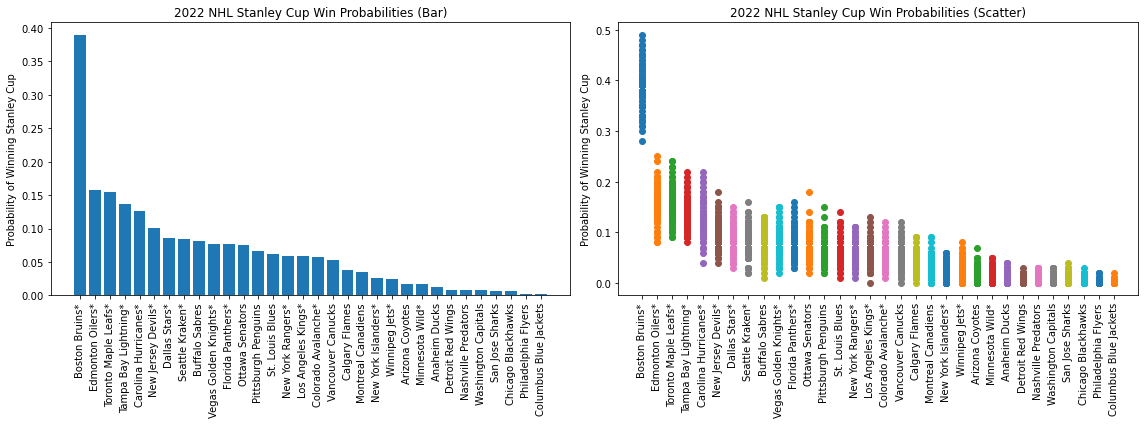

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.bar(sorted_team_names, sorted_team_probs)
ax1.set_xticks(range(len(sorted_team_names)))
ax1.set_xticklabels(sorted_team_names, rotation=90)
ax1.set_ylabel('Probability of Winning Stanley Cup')
ax1.set_title('2022 NHL Stanley Cup Win Probabilities (Bar)')

for team in sorted_team_names:
    probs = team_prob_dict[team]
    ax2.scatter([team] * len(probs), probs, label=team)

ax2.set_ylabel('Probability of Winning Stanley Cup')
ax2.set_title('2022 NHL Stanley Cup Win Probabilities (Scatter)')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

<a id="2023simulatingnorandom"></a>
## Simulating 2023 Playoffs - No Randomness
[Return to top](#top)
- This cell will provide the same output each time based on team probabilities

In [41]:
matchups = [
    ("Florida Panthers*", "Boston Bruins*"),
    ("New York Islanders*", "Carolina Hurricanes*"),
    ("New York Rangers*", "New Jersey Devils*"),
    ("Tampa Bay Lightning*", "Toronto Maple Leafs*"),
    ("Winnipeg Jets*", "Vegas Golden Knights*"),
    ("Los Angeles Kings*", "Edmonton Oilers*"),
    ("Seattle Kraken*", "Colorado Avalanche*"),
    ("Minnesota Wild*", "Dallas Stars*"),
]

rounds = 1
matchup_results = {}

while len(matchups) > 0:
    winners = []
    round_results = {}
    for team1, team2 in matchups:
        winner = simulate_match(team1, team2, team_probs)
        winners.append(winner)
        round_results[f"{team1} vs {team2}"] = f"{winner} wins"
    
    matchup_results[f"Round {rounds}"] = round_results
    rounds += 1

    if len(winners) > 1:
        matchups = [(winners[i], winners[i+1]) for i in range(0, len(winners), 2)]
    else:
        break

for round_name, results in matchup_results.items():
    print(round_name)
    for matchup, result in results.items():
        print(matchup, ":", result)
    print()

print("Champion:", winners[0])

Round 1
Florida Panthers* vs Boston Bruins* : Boston Bruins* wins
New York Islanders* vs Carolina Hurricanes* : Carolina Hurricanes* wins
New York Rangers* vs New Jersey Devils* : New Jersey Devils* wins
Tampa Bay Lightning* vs Toronto Maple Leafs* : Toronto Maple Leafs* wins
Winnipeg Jets* vs Vegas Golden Knights* : Vegas Golden Knights* wins
Los Angeles Kings* vs Edmonton Oilers* : Edmonton Oilers* wins
Seattle Kraken* vs Colorado Avalanche* : Seattle Kraken* wins
Minnesota Wild* vs Dallas Stars* : Dallas Stars* wins

Round 2
Boston Bruins* vs Carolina Hurricanes* : Boston Bruins* wins
New Jersey Devils* vs Toronto Maple Leafs* : Toronto Maple Leafs* wins
Vegas Golden Knights* vs Edmonton Oilers* : Edmonton Oilers* wins
Seattle Kraken* vs Dallas Stars* : Dallas Stars* wins

Round 3
Boston Bruins* vs Toronto Maple Leafs* : Boston Bruins* wins
Edmonton Oilers* vs Dallas Stars* : Edmonton Oilers* wins

Round 4
Boston Bruins* vs Edmonton Oilers* : Boston Bruins* wins

Champion: Boston Br

<a id="2023simulatingrandom"></a>
## Simulating 2023 Playoffs - With Randomness
[Return to top](#top)
- Everytime this cell is ran the outcomes can change due to randomness
- As you increase the strength value, the effect of the probabilities will become more significant, and randomness will have less influence on the outcomes

In [42]:
matchups = [
    ("Florida Panthers*", "Boston Bruins*"),
    ("New York Islanders*", "Carolina Hurricanes*"),
    ("New York Rangers*", "New Jersey Devils*"),
    ("Tampa Bay Lightning*", "Toronto Maple Leafs*"),
    ("Winnipeg Jets*", "Vegas Golden Knights*"),
    ("Los Angeles Kings*", "Edmonton Oilers*"),
    ("Seattle Kraken*", "Colorado Avalanche*"),
    ("Minnesota Wild*", "Dallas Stars*"),
]

rounds = 1
matchup_results = {}

while len(matchups) > 0:
    winners = []
    round_results = {}
    for team1, team2 in matchups:
        winner = simulate_match_random(team1, team2, team_probs, strength = 10)
        winners.append(winner)
        round_results[f"{team1} vs {team2}"] = f"{winner} wins"
    
    matchup_results[f"Round {rounds}"] = round_results
    rounds += 1

    if len(winners) > 1:
        matchups = [(winners[i], winners[i+1]) for i in range(0, len(winners), 2)]
    else:
        break

for round_name, results in matchup_results.items():
    print(round_name)
    for matchup, result in results.items():
        print(matchup, ":", result)
    print()

print("Champion:", winners[0])

Round 1
Florida Panthers* vs Boston Bruins* : Boston Bruins* wins
New York Islanders* vs Carolina Hurricanes* : Carolina Hurricanes* wins
New York Rangers* vs New Jersey Devils* : New Jersey Devils* wins
Tampa Bay Lightning* vs Toronto Maple Leafs* : Tampa Bay Lightning* wins
Winnipeg Jets* vs Vegas Golden Knights* : Vegas Golden Knights* wins
Los Angeles Kings* vs Edmonton Oilers* : Edmonton Oilers* wins
Seattle Kraken* vs Colorado Avalanche* : Seattle Kraken* wins
Minnesota Wild* vs Dallas Stars* : Dallas Stars* wins

Round 2
Boston Bruins* vs Carolina Hurricanes* : Boston Bruins* wins
New Jersey Devils* vs Tampa Bay Lightning* : Tampa Bay Lightning* wins
Vegas Golden Knights* vs Edmonton Oilers* : Edmonton Oilers* wins
Seattle Kraken* vs Dallas Stars* : Seattle Kraken* wins

Round 3
Boston Bruins* vs Tampa Bay Lightning* : Boston Bruins* wins
Edmonton Oilers* vs Seattle Kraken* : Edmonton Oilers* wins

Round 4
Boston Bruins* vs Edmonton Oilers* : Boston Bruins* wins

Champion: Bosto